In [1]:
import transformers
from transformers import pipeline
print(transformers.__version__)

c:\ProgramData\anaconda3\envs\transformer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.32.0


In [2]:
sentiment = pipeline("sentiment-analysis")
print(sentiment("I like Olypic games beacause Compatition is beautiful thing i think. But play in front fo my house? I don't want it."))


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.996731162071228}]


In [3]:
qa = pipeline("question-answering")
olympic_wiki = "The 2020 Summer Olympics,[3] officially the Games of the XXXII Olympiad[4] and also known as Tokyo 2020,[5] was an international multi-sport event held from 23 July to 8 August 2021 in Tokyo, Japan, with some preliminary events that began on 21 July 2021. Tokyo was selected as the host city during the 125th IOC Session in Buenos Aires, Argentina, on 7 September 2013. Originally scheduled to take place from 24 July to 9 August 2020, the event was postponed to 2021 on 24 March 2020 due to the global COVID-19 pandemic, the first such instance in the history of the Olympic Games (previous games had been cancelled but not rescheduled).[7] However, the event retained the Tokyo 2020 branding for marketing purposes.[8] It was largely held behind closed doors with no public spectators permitted due to the declaration of a state of emergency in the Greater Tokyo Area in response to the pandemic, the first and only Olympic Games to be held without official spectators.[c] The Games were the most expensive ever, with total spending of over $20 billion.[10] The Games were the fourth Olympic Games to be held in Japan, following the 1964 Summer Olympics (Tokyo), 1972 Winter Olympics (Sapporo), and 1998 Winter Olympics (Nagano). Tokyo became the first city in Asia to hold the Summer Olympic Games twice.[d] The 2020 Games were the second of three consecutive Olympics to be held in East Asia, following the 2018 Winter Olympics in Pyeongchang, South Korea and preceding the 2022 Winter Olympics in Beijing, China. Due to the one-year postponement, Tokyo 2020 was the first and only Olympic Games to have been held in an odd-numbered year[12] and the first Summer Olympics since 1900 to be held in a non-leap year. New events were introduced in existing sports, including 3x3 basketball, freestyle BMX and mixed gender team events in a number of existing sports, as well as the return of madison cycling for men and an introduction of the same event for women. New IOC policies also allowed the host organizing committee to add new sports to the Olympic program for just one Games. The disciplines added by the Japanese Olympic Committee were baseball and softball, karate, sport climbing, surfing and skateboarding, the last four of which made their Olympic debuts, and the last three of which will remain on the Olympic program.[13] The United States topped the medal count by both total golds (39) and total medals (113), with China finishing second by both respects (38 and 89). Host nation Japan finished third, setting a record for the most gold medals and total medals ever won by their delegation at an Olympic Games with 27 and 58. Great Britain finished fourth, with a total of 22 gold and 64 medals. The Russian delegation competing as the ROC finished fifth with 20 gold medals and third in the overall medal count, with 71 medals. Bermuda, the Philippines and Qatar won their first-ever Olympic gold medals.[14][15][16] Burkina Faso, San Marino and Turkmenistan also won their first-ever Olympic medals."
print(qa(question = "What caused Tokyo Olymipic postponed?",context = olympic_wiki))

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.5584240555763245, 'start': 496, 'end': 520, 'answer': 'global COVID-19 pandemic'}


In [4]:
import random
from torchtext.datasets import IMDB
random.seed(6)

train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

train_list_small = random.sample(list(train_iter),1000)
test_list_small = random.sample(list(test_iter),1000)

In [5]:
train_texts = []
train_labels =[]
for label, text in train_list_small:
    train_labels.append(1 if label==2 else 0)
    train_texts.append(text)
    
test_texts =[]
test_labels =[]
for label, text in train_list_small:
    test_labels.append(1 if label==2 else 0)
    test_texts.append(text)
    
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts,train_labels, test_size=0.2, random_state=6)
   

In [6]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encoding = tokenizer(train_texts,truncation=True,padding=True)
test_encoding = tokenizer(test_texts,truncation=True,padding=True)
val_encoding = tokenizer(val_texts,truncation=True,padding=True)

print(train_encoding["input_ids"][0][:10])
print(tokenizer.decode(train_encoding["input_ids"][0][:10]))

[101, 2023, 2003, 2025, 1037, 2919, 3185, 1012, 2009, 4076]
[CLS] this is not a bad movie. it follows


In [7]:
import torch


class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self,encoding,labels):
        super(IMDBDataset,self)
        self.encoding = encoding
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        items = {key: torch.tensor(value[idx]) for key,value in self.encoding.items()}
        items['labels'] = torch.tensor(self.labels[idx])
    
        return items
    
train_dataset = IMDBDataset(train_encoding,train_labels)
val_dataset = IMDBDataset(val_encoding,val_labels)
test_dataset =  IMDBDataset(test_encoding,test_labels)

In [8]:
from transformers import DistilBertForSequenceClassification
from transformers import TrainingArguments
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
traning_args  = TrainingArguments(
    output_dir= './result',
    num_train_epochs= 10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size= 64,
    warmup_steps= 100,
    weight_decay= 0.01,
    logging_dir='./logs',
    logging_steps=10,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


In [10]:
# test_inference 함수 생성
def test_inference(model, tokenizer):
  input_tokens = tokenizer(["My life is great!","I don't have much time for study of conputers.","I feel fantastic",
                            "My life is going something wrong", 
                            "I have not figured out what the chosen title has to do with the movie."], 
                           truncation=True, padding=True)
  outputs = model(torch.tensor(input_tokens['input_ids']).to(device))
  # 영어 원문의 1과 0값 배정고 달리 일반적인 용례에 따라 변경
  label_dict = {1:'p', 0:'n'}
  return [label_dict[i] for i in torch.argmax(outputs['logits'], axis=1).cpu().numpy()]

In [11]:
# from transformers import Trainer
# trainer = Trainer(model= model,
#                   args = traning_args,
#                   train_dataset = train_dataset,
#                   eval_dataset = val_dataset)

# trainer.train()


In [12]:

from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import DistilBertTokenizerFast
import matplotlib.pyplot as plt

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)

print(test_inference(model, tokenizer))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optim = AdamW(model.parameters(), lr=5e-5)
# model.train()

losses = []


for epoch in range(10):
    print(f'epoch:{epoch}')
    for batch in train_loader:

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        losses.append(loss)
        #역전파
        loss.backward()
        optim.step()
# 모델을 eval 모드로 전환
model.eval()

# eval 모드를 사용하여 test_inference 함수 실행
print(test_inference(model, tokenizer))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


['p', 'p', 'p', 'p', 'p']
epoch:0


c:\ProgramData\anaconda3\envs\transformer\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch:1
epoch:2
epoch:3
epoch:4
['p', 'n', 'p', 'p', 'n']


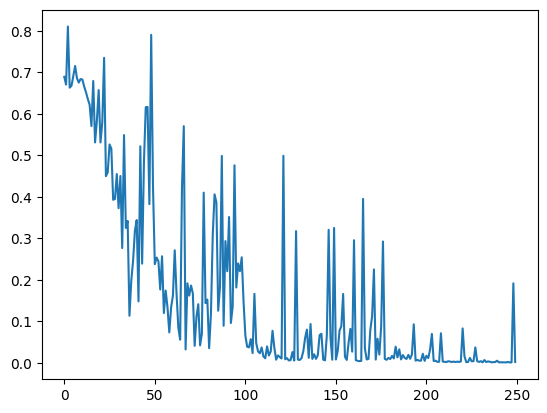

In [22]:
import numpy as np
#new_losses = np.array(losses)
new_losses = [i.item() for i in losses]
plt.plot(new_losses)
plt.show()

In [27]:
model.eval()
l = []

for test in test_texts:
    input_token = tokenizer([test], truncation=True, padding=True)
    output = model(torch.tensor(input_token['input_ids']).to(device))
    #l.append(torch.argmax(outputs['logits'],axis = 1).item())
    l.extend(torch.argmax(outputs['logits'], axis=1).tolist())#하나씩 처리하기때문에 tolist를 사용함

correct =0
for pred, ans in zip(l,test_labels):
    if pred == ans:
        correct +=1 
        
print(correct/len(test_labels))

0.486


In [28]:
# 각 변수의 초기값을 0으로 설정
tp = 0
tn = 0
fp = 0
fn = 0

# 리스트 l과 test_labels를 zip( )을 통해 쌍(pair)으로 묶은 후 각기 pred와 ans라는 변수로 추출
# zip()안의 데이터 쌍이 소진될 때까지 반복문을 실행
for pred, ans in zip(l, test_labels):

  # tp 계산
  if pred == ans:
    if pred ==1:
      tp += 1
    else:
      tn += 1

  # fn 계산
  elif pred == 0:
    fn += 1

  # fp 계산
  elif pred == 1:
    fp +=1


In [30]:
recall = tp/(tp+fn)
print("재현율: ",recall)
precision = tp/(tp+fp)
print("정밀도: ",precision)
print("F1 Score:",(2 * precision * recall) / (precision + recall))

재현율:  0.48627450980392156
정밀도:  0.496
F1 Score: 0.491089108910891


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, l))
